In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve
%matplotlib inline

Part A: Model Code (60 pts)

1. Write a function to calculate and return the Minkowski distance with optional argument p
defaulting to ‘p=2’ (Euclidean) of two vectors where a vector represents a data point. [6 pts]

In [7]:
# @p: Integer power value
def minkowski_dist(vecA, vecB, p=2):
    assert len(vecA) == len(vecB)
    assert isinstance(p, int)
    sum = 0
    for i in range(len(vecA)):
        abs_diff = abs(vecA[i] - vecB[i])
        sum += pow(abs_diff, p)
        print(sum)
    return pow(sum, 1/p)
    

2. Write a function to calculate and return the accuracy of two vectors. [4 pts]

In [8]:
# @gold: binary vector representing gold data
# @pred: binary vector representing predicted data
def vector_accuracy(gold, pred):
    assert len(gold) == len(pred)
    count = 0
    for i in range(len(gold)):
        if gold[i] == pred[i]:
            count += 1
    return count/len(gold)


3. Write three functions to compute: precision, recall and F1 score. [6 pts]

In [9]:
# @rel: Relevant instances
# @ret: Retrieved instances
def precision(rel, ret):
    set_rel=set(rel)
    set_ret=set(ret)
    return len(set_rel.intersection(set_ret))/len(set_ret)

# @rel: Relevant instances
# @ret: Retrieved instances
def recall(rel, ret):
    set_rel=set(rel)
    set_ret=set(ret)
    return len(set_rel.intersection(set_ret))/len(set_rel)

# @rel: Relevant instances
# @ret: Retrieved instances
def F1_score(rel, ret):
    pre = precision(rel, ret)
    rec = recall(rel, ret)
    return 2*pre*rec/(pre+rec)


4. Write a function to compute the confusion matrix of two vectors. [4 pts]

In [10]:
# @gold: binary vector representing gold data
# @pred: binary vector representing predicted data
def confusion_matrix(gold, pred):
    assert len(gold) == len(pred)
    tp = fp = tn = fn = 0
    for i in range(len(gold)):
        if gold[i] and pred[i]:
            tp += 1
        elif gold[i] and not pred[i]:
            fn += 1
        elif not gold[i] and pred[i]:
            fp += 1
        else:
            tn += 1
    return [[tp,fn], \
            [fp,tn]]
        

5. Write a function to generate the Receiver Operating Characteristic (ROC) curve. [5 pts]

In [61]:
# @gold: binary vector representing gold data
# @pred: binary vector representing predicted data
def clf_curve(gold, pred):
    assert len(gold) == len(pred)
    pred = np.array(pred)
    gold = np.array(gold)
    
    # Sort the predicted values in
    # descending order along with their
    # corresponding gold values.
    pred_desc = np.argsort(pred)[::-1]
    pred = pred[pred_desc]
    gold = gold[pred_desc]

    # Remove redundant values
    distinct_indices = np.where(np.diff(pred))[0]
    end = np.array([gold.size - 1])
    threshold_indices = np.concatenate((distinct_indices, end))
    
    # Get threshold values
    thresholds = pred[threshold_indices]
    
    # Get count vectors for true and false positives
    tp_count = np.cumsum(gold)[threshold_indices]
    fp_count = (1 + threshold_indices) - tp_count

    return tp_count, fp_count, thresholds

# @gold: binary vector representing gold data
# @pred: binary vector representing predicted data
def roc_curve(gold, pred):
    
    tp_count, fp_count, thresholds = clf_curve(gold, pred)
    
    # Add an extra threshold position
    # to make sure that the curve starts at (0, 0)
    tp_count = np.r_[0, tp_count]
    fp_count = np.r_[0, fp_count]
    thresholds = np.r_[thresholds[0] + 1, thresholds]
    
    total_negatives = fp_count[-1]
    total_positives = tp_count[-1]
    fp_rate = fp_count / total_negatives
    tp_rate = tp_count / total_positives
    
    return fp_rate, tp_rate, thresholds

# @fp_rate: false positive rate
# @tp_rate: true positive rate
# @thresholds: Points of change in the confsion matrix
def plot_roc_curve(fp_rate, tp_rate, thresholds):
    plt.plot(fp_rate, tp_rate)
    plt.scatter(fp_rate,tp_rate)

    

6. Write a function to compute area under curve (AUC) for the ROC curve. [5 pts]

In [43]:
# @x: Float vector of independent variable
# @y: Float vector of dependent variable
def area_under_curve(x,y):
    assert len(x) == len(y)
    AUC = 0
    for i in range(len(x)-1):
        if x[i+1] > x[i]:
            AUC += area_under_line(x[i],y[i],x[i+1],y[i+1])
    return AUC

def area_under_line(x1, y1, x2, y2):
    if y1 == y2:
        return y1*(x2-x1)
    elif y1 < y2:
        tri_area = (x2-x1)*(y2-y1)/2
        rect_area = y1*(x2-x1)
        return tri_area + rect_area
    else:
        raise Exception("Error in ROC curve")
        

7. Write a function to generate the precision-recall curve. [5 pts]

In [59]:
# @gold: binary vector representing gold data
# @pred: binary vector representing predicted data
def pr_curve(gold, pred):
    tp_count, fp_count, thresholds = clf_curve(gold, pred)
  
    total_positives = tp_count[-1]
    precision = tp_count / (tp_count + fp_count)
    recall = tp_count / total_positives
    
    index = tp_count.searchsorted(total_positives)
    slc = slice(index, None, -1)
    
    precision = np.r_[precision[slc], 1]
    recall = np.r_[recall[slc], 0]
    thresholds = thresholds[slc]
    
    return precision, recall, thresholds

# @prec: precision vector
# @recall: recall vector
# @thresholds: Points of change in the confsion matrix
def plot_pr_curve(prec, recall, thresholds):
    plt.plot(prec, recall)
    plt.scatter(prec, recall)



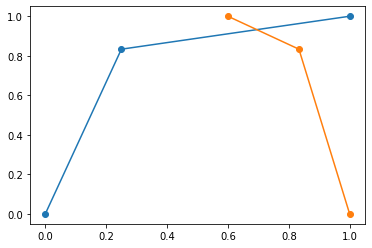

In [63]:
my_gold = [1,1,0,0,1,1,1,0,1,0]
my_pred = [1,0,1,0,1,1,1,0,1,0]
x,y,thresh = roc_curve(my_gold,my_pred)
plot_roc_curve(x,y,thresh)
x,y,thresh = pr_curve(my_gold, my_pred)
plot_pr_curve(x,y,thresh)


Part B: Data Processing, Feature Selection, and Initial Estimation (40 pts)


10. Read in the winequality-white.csv file as a Pandas data frame.

In [2]:
wine_data = pd.read_csv("winequality-white.csv", delimiter=';')
